# Targeted Dropout

Paper: https://openreview.net/pdf?id=HkghWScuoQ

**Note** Accuracies are low as I am using very less data for the sake of analysis.

### Dependencies

In [1]:
import tensorflow as tf; print("Tensorflow: ", tf.__version__)
import matplotlib.pyplot as plt; import matplotlib; print("Matplotlib: ", matplotlib.__version__)
import seaborn as sns; print("Seaborn: ", sns.__version__)
import numpy as np; print("Numpy: ", np.__version__)
import pandas as pd; print("Pandas: ", pd.__version__)
from pprint import pprint
mnist = tf.keras.datasets.mnist
tf.enable_eager_execution()
tf.set_random_seed(42)

import dropout_functions

Tensorflow:  1.12.0
Matplotlib:  3.0.2
Seaborn:  0.9.0
Numpy:  1.15.4
Pandas:  0.18.1


## Using a small subset of MNIST data for fast analysis

In [2]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
idx = np.random.choice(range(x_train.shape[0]),size=1000)
x_train, y_train = x_train[idx], y_train[idx]
idx = np.random.choice(range(x_train.shape[0]),size=100)
x_test, y_test = x_test[idx], y_test[idx]

## Vanilla Unregularized DNN

In [3]:
def get_model_unregularized():
    return tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
        tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
        tf.keras.layers.Dense(500, activation=tf.nn.relu, use_bias=False),
        tf.keras.layers.Dense(200, activation=tf.nn.relu, use_bias=False),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax, use_bias=False)
    ])

In [4]:
model = get_model_unregularized()
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5,verbose=2, use_multiprocessing=True)
print(model.metrics_names ,model.evaluate(x_test, y_test, verbose=2))

Epoch 1/5
 - 0s - loss: 1.1145 - acc: 0.6172
Epoch 2/5
 - 0s - loss: 0.4440 - acc: 0.8662
Epoch 3/5
 - 0s - loss: 0.1873 - acc: 0.9492
Epoch 4/5
 - 0s - loss: 0.1471 - acc: 0.9600
Epoch 5/5
 - 0s - loss: 0.0913 - acc: 0.9736
['loss', 'acc'] [0.5825237452983856, 0.87]


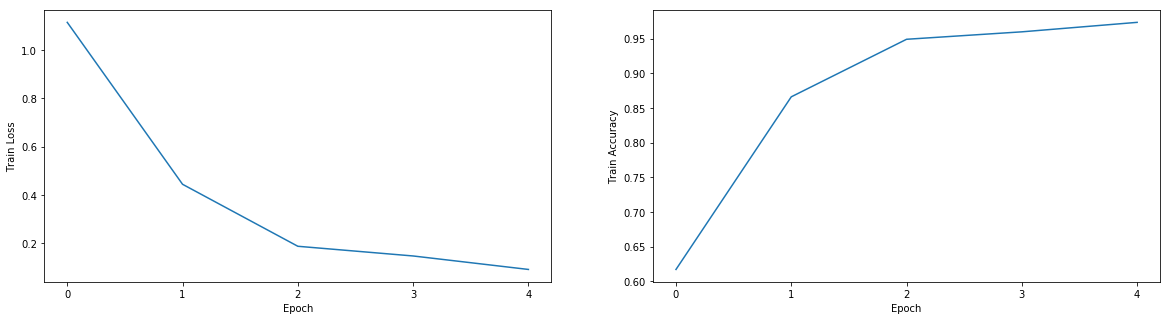

In [5]:
df = pd.DataFrame(model.history.history)
plt.figure(1, figsize=(20,5))
plt.subplot(121)
plt.plot(df["loss"])
plt.xticks(df.index)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.subplot(122)
plt.plot(df["acc"])
plt.xticks(df.index)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy');
plt.show()

# Pruning Methods

In [6]:
def mask_for_big_values(weights, pruning_threshold):
    small_weights = np.abs(weights) < pruning_threshold
    return np.logical_not(small_weights)

def prune_weights(model, pruning_perc=10):
    weights = model.get_weights()
    weight_matrices_tf = model.weights
    for (weight_matrix,
         tf_weight_matrix,
        ) in zip(
         weights[:-1],
         weight_matrices_tf[:-1],
        ):
        tres = np.percentile(np.abs(weight_matrix), pruning_perc)
        mask = mask_for_big_values(weight_matrix, tres)
        tf_weight_matrix.assign(weight_matrix * mask)



In [7]:
model = get_model_unregularized()
model.compile(optimizer=tf.train.AdamOptimizer(),
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5,verbose=2)
model.evaluate(x_test, y_test, verbose=0)

Epoch 1/5
 - 0s - loss: 1.0836 - acc: 0.6504
Epoch 2/5
 - 0s - loss: 0.3729 - acc: 0.8779
Epoch 3/5
 - 0s - loss: 0.1850 - acc: 0.9424
Epoch 4/5
 - 0s - loss: 0.1130 - acc: 0.9609
Epoch 5/5
 - 0s - loss: 0.0541 - acc: 0.9814


[0.5998013663291931, 0.84]

### Distribution before pruning

/home/f20160295/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


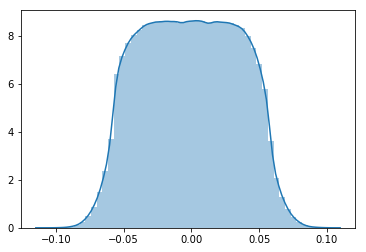

In [8]:
sns.distplot(model.layers[1].get_weights()[0].flatten())
plt.show()

In [9]:
prune_weights(model, 50)
model.compile(optimizer=tf.train.AdamOptimizer(),
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
print(model.evaluate(x_test, y_test, verbose=0))
[layer.units for layer in model.layers[1:]]

[0.533827543258667, 0.85]


[1000, 1000, 500, 200, 10]

### Distribution after pruning

/home/f20160295/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


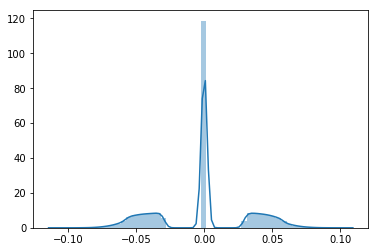

In [10]:
sns.distplot(model.layers[1].get_weights()[0].flatten())
plt.show()

# Weight Targeted Dropout with Pruning

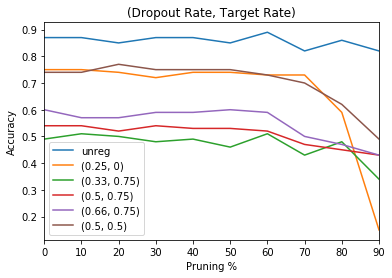

,unreg,"(0.25, 0)","(0.33, 0.75)","(0.5, 0.75)","(0.66, 0.75)","(0.5, 0.5)"
Pruning %,,,,,,
0,0.87,0.75,0.49,0.54,0.6,0.74
10,0.87,0.75,0.51,0.54,0.57,0.74
20,0.85,0.74,0.5,0.52,0.57,0.77
30,0.87,0.72,0.48,0.54,0.59,0.75
40,0.87,0.74,0.49,0.53,0.59,0.75
50,0.85,0.74,0.46,0.53,0.6,0.75
60,0.89,0.73,0.51,0.52,0.59,0.73
70,0.82,0.73,0.43,0.47,0.5,0.7
80,0.86,0.59,0.48,0.45,0.47,0.62


In [11]:
confs = ["unreg", (0.25, 0), (0.33, 0.75), (0.5,0.75),(0.66,0.75),(0.5, 0.5)]
dfw = pd.DataFrame(columns=confs, index=range(0,100,10))
for conf in confs:
    if conf=="unreg":
        model = get_model_unregularized()
    else:
        model = dropout_functions.get_targeted_dropout_model("weight", conf)
    
    model.compile(optimizer=tf.train.AdamOptimizer(),
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5,verbose=0)
    for pruning in range(0,100,10):
        prune_weights(model, pruning)
        dfw[conf][pruning] = model.evaluate(x_test, y_test, verbose=0)[1]
dfw.index.name = "Pruning %"
dfw.plot();
plt.xlabel("Pruning %")
plt.ylabel("Accuracy")
plt.title("(Dropout Rate, Target Rate)")
plt.show();
dfw

# Unit Targeted Dropout with Pruning

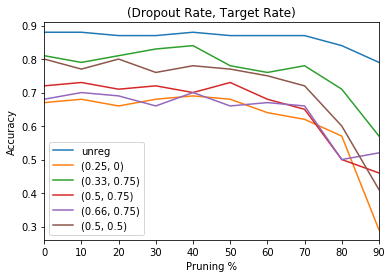

,unreg,"(0.25, 0)","(0.33, 0.75)","(0.5, 0.75)","(0.66, 0.75)","(0.5, 0.5)"
Pruning %,,,,,,
0,0.88,0.67,0.81,0.72,0.68,0.8
10,0.88,0.68,0.79,0.73,0.7,0.77
20,0.87,0.66,0.81,0.71,0.69,0.8
30,0.87,0.68,0.83,0.72,0.66,0.76
40,0.88,0.69,0.84,0.7,0.7,0.78
50,0.87,0.68,0.78,0.73,0.66,0.77
60,0.87,0.64,0.76,0.68,0.67,0.75
70,0.87,0.62,0.78,0.65,0.66,0.72
80,0.84,0.57,0.71,0.5,0.5,0.6


In [12]:
confs = ["unreg", (0.25, 0), (0.33, 0.75), (0.5,0.75),(0.66,0.75),(0.5, 0.5)]

dfu = pd.DataFrame(columns=confs, index=range(0,100,10))
for conf in confs:
    if conf=="unreg":
        model = get_model_unregularized()
    else:
        model = dropout_functions.get_targeted_dropout_model("unit", conf)
    
    model.compile(optimizer=tf.train.AdamOptimizer(),
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5,verbose=0)
    for pruning in range(0,100,10):
        prune_weights(model, pruning)
        model.compile(optimizer=tf.train.AdamOptimizer(),
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
        dfu[conf][pruning] = model.evaluate(x_test, y_test, verbose=0)[1]
dfu.index.name = "Pruning %"
dfu.plot();
plt.xlabel("Pruning %")
plt.ylabel("Accuracy")
plt.title("(Dropout Rate, Target Rate)")
plt.show()
dfu

# Analysis
Weights Pruning simplified, is setting a set of cells of less consequence in a matrix to 0 after training. And Weight Dropout uses similar idea while training. We are deleting connections.

Unit Pruning and Dropout similarly extends the idea to an entire neuron. Here we delete rows and corresponing columns(in the next layer) in the weight matrices which are of less consequence.

We can see that weight targeted dropout gives comparable accuracies until ~70% pruning where as unit targeted pruning loses accuracies after ~40% pruning. 

Different combination of targeted rate and dropout rate are good for unit dropout and weight dropout. Unit dropout does best with `(alpha= 0.33, gamma= 0.75)` configuration whereas weight dropout does well with `(alpha=0.5, gamma=0.5)` configuration. 

This might be a model dependent phenomenon.

### General Advantages of Pruning:
- Reduce Model Size
- Decrease inference/prediction time and computation
- Introduces some amount of regularization.

### General Advantages of Dropout:
- Regularization
- Reduces/prevents dominance of few connections or neurons.

### Contributions of Targeted Dropout:
- Ignoring connections or neurons with less magnitude. Stochasticity gives the connections and neurons multiple chances to contribute to the decision procedure.
- The goal is opposite to vanilla dropout's goal, to ignore less efficient connections/neurons.
- Model building simplified, i.e, we could start with a very general model and let the dropout+pruning decide the best model size.


# Further Work 

## Layer wise Pruning and Targeted Dropout

Extrapolating this idea, we could do the same with entire layers. We could essentially fuse layers. This might prove very useful in deep networks.

We can look for nonlinearities present between layers which are not contributing to the performance. By removing such non-linearities, we are left with pairs of weight matrices, which can be "fused" by multiplying them.

Some metrics to find such non-linearities:
- L2 or L1 distance between `layer2(layer1(input))` and `fusedLayer(input)`.
- L2 or L1 norm of gradients of pairs of layers. To weigh their contribution to the final performance.

## Combination of Vanilla Dropout and Targeted Dropout
Why? 
I believe Vanilla Dropout and Targeted Dropout are trying to achieve opposite goals.

Former is trying to make weaker connections/neruons stronger and also avoiding dependency on small set of connections or neurons. Latter is trying to ignore weakly performing connections/neruons while giving them a fair chance to recover.

A combination of both might help us acheive robustness as well as better model efficiency at the same time.
